# Stochastic, metapopulation, age-stratified SI2R

In this notebook we will present a model that partitions the population in four compartments: susceptibles, $S$, who can catch the disease; infected presymptomatic, $I^p$, that has caught the infection and are infectious but cannot be considered yet symptomatic nor asymptomatic;  asymptomatic infectives, $I^a$, who have already caught the disease and are infectives but do not present (nor will present) any symptoms of the infection; symptomatic infectives, $I^s$, who have already caught the disease and are infectives and symptomatic; and removed individuals, R. 

Since the epidemiological dynamics is much faster than the demographical one and there is no deaths considered in the model, the sum $N=S+I^p+I^a+I^s+R$ remains constant.

The ordinary differential equations of the SI3R model are (for each age group $i$):

\begin{align}
\dot S_i &= -\lambda(t)_i S_i \\
\dot I_i^p &= \lambda(t)_i S_i - \gamma_i^{I^p} I_i^p \\
\dot I_i^a &= \alpha_i \gamma_i^{I^p} I_i^p - \gamma_i^{I^a} I_i^a \\
\dot I_i^s &= \bar{\alpha_i} \gamma_i^{I^p} I_i^p - \gamma_i^{I^s} I_i^s \\
\dot R_i &= \gamma_i^{I^a} I_i^a + \gamma_i^{I^s} I_i^s
\end{align}

The rate at which the susceptibles get infected is 
$$
\lambda_i(t) = \beta \sum_{j=1}^M (C_{ij}^a \frac{I_j^p}{N_j} + C_{ij}^p \frac{I_j^a}{N_j} + C_{ij}^s \frac{I_j^s}{N_j})
$$
where the parameter $\beta$ is the probability of infection on contact. 

Let's start by considering the infected in all states and age groups are equally contagious ($C_{ij}^p = C_{ij}^a = C_{ij}^s  = C_{ij}$):

\begin{align}
\lambda_i(t) &= \beta \sum_{j=1}^M (C_{ij} \frac{I_j^p}{N_j} + C_{ij} \frac{I_j^a}{N_j} + C_{ij} \frac{I_j^s}{N_j})\\
\lambda_i(t) &= \beta \sum_{j=1}^M C_{ij} (\frac{I_j^p}{N_j} + \frac{I_j^a}{N_j} + \frac{I_j^s}{N_j})
\end{align}

Then, we consider that they contagiusness is constant over time we can obtain a much simpler expression:

$$
\lambda_i = \beta C_i \sum_{j=1}^M(\frac{I_j^p}{N_j} + \frac{I_j^a}{N_j} + \frac{I_j^s}{N_j})
$$

(Esto último tengo que ver bien como lo escribo, la idea es que no sean 200 mil parámetros)

In [1]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
#from matplotlib import rc; rc('text', usetex=True)
from time import perf_counter

### Simulation of a single stochastic trajectory

In [8]:
M = 1                  # the SIR model has no age structure
Ni = 3000*np.ones(M)   # so there is only one age group 
N = np.sum(Ni)         # and the total population is the size of this age group

beta  = 0.9             # infection rate 
gIp   = 0.15            # removal rate of presymptomatic infectives 
gIa   = 0.15            # removal rate of asymptomatic infectives 
gIs   = 0.15            # removal rate of symptomatic infectives 
alpha = .2              # fraction of asymptomatic infectives 
fsa   = 1               # Fraction by which symptomatic individuals do not self isolate


Ip0 = np.array([15])    # we take these to be symptomatic 
Ia0 = np.array([0])     # the SIR model has only one kind of infective 
Is0 = np.array([5])     # we take these to be symptomatic 
R0  = np.array([0])     # and assume there are no removed individuals initially 
S0  = N-(Ia0+Ip0+Is0+R0)    # so that the initial susceptibles are obtained from S + Ia + Is + R = N

# there is no contact structure
def contactMatrix(t):   
    return np.identity(M) 

# duration of simulation and data file
Tf = 99;  Nt=Tf+1; 

In [9]:
# instantiate model
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIp':gIp, 'gIs':gIs, 'fsa':fsa}
model = pyross.stochastic.SI2R(parameters, M, Ni)

In [10]:
# simulate model 
t_ini = perf_counter()
data = model.simulate(S0, Ip0, Ia0, Is0, contactMatrix, Tf, Nt)
#data = model.simulate(x0, contactMatrix, Tf, Nf)
t_end = perf_counter() - t_ini
print(t_end)

0.1652465420193039


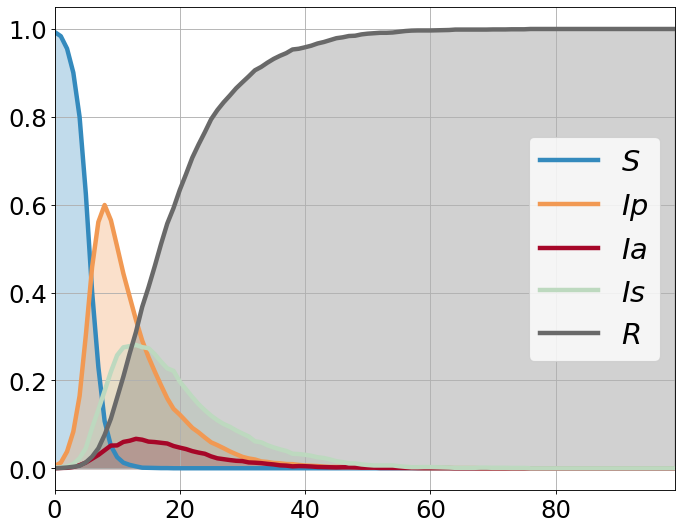

In [11]:
# plot the data and obtain the stochastic epidemic curve
S  = data['X'][:,0].flatten()
Ip = data['X'][:,1].flatten()
Ia = data['X'][:,2].flatten()
Is = data['X'][:,3].flatten()
t = data['t']


fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.fill_between(t, 0, Ip/N, color='#F19953', alpha=0.3)
plt.plot(t, Ip/N, '-', color='#F19953', label='$Ip$', lw=4)

plt.fill_between(t, 0, Ia/N, color='#A60628', alpha=0.3)
plt.plot(t, Ia/N, '-', color='#A60628', label='$Ia$', lw=4)

plt.fill_between(t, 0, Is/N, color='#BDD9BF', alpha=0.3)
plt.plot(t, Is/N, '-', color='#BDD9BF', label='$Is$', lw=4)

R=N-S-Ia-Ip-Is; plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)

Note that, since here sample trajectories for the stochastic model are generated, a slightly different plot will result every time the two cells above are run. 


### Averaging over several simulations

If the simulation is run many times, mean and standard deviation of the resulting trajectories can be calculated and compared to the deterministic SIR model.

In [7]:
# run 100 simulations, calculate mean and standard deviation

N_runs = 1000
trajectories_s = np.zeros([N_runs,Nt,4],dtype=float)

t_ini = perf_counter()
for i in range(N_runs):
    cur_result = model.simulate(S0, Ip0, Ia0, Is0, contactMatrix, Tf, Nt)
    trajectories_s[i] = cur_result['X']
t_end = perf_counter() - t_ini
print(t_end)

t_s = cur_result['t']
mean_s = np.mean(trajectories_s,axis=0)
std_s = np.std(trajectories_s,axis=0)

144.43294429103844


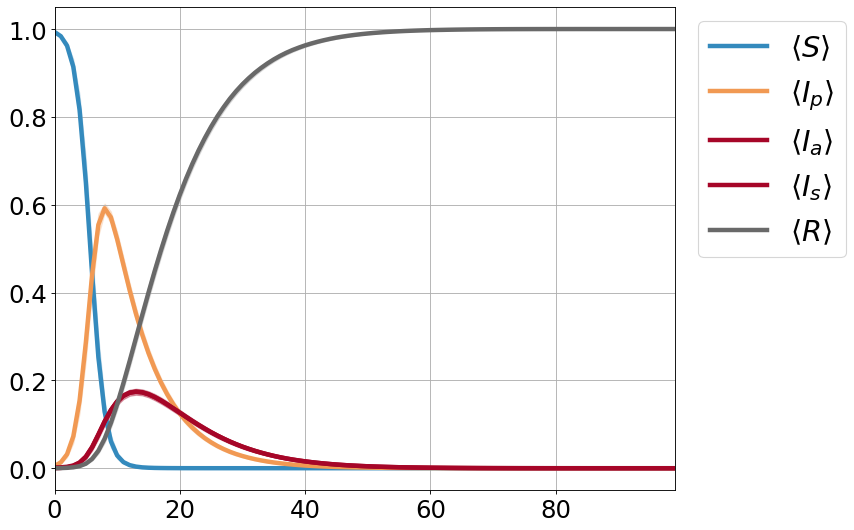

In [57]:
# plot mean and standard deviation

S_s  = mean_s[:,0].flatten()
Ip_s = mean_s[:,1].flatten()
Ia_s = mean_s[:,2].flatten()
Is_s = mean_s[:,3].flatten()
dS_s = std_s[:,0].flatten()
dIp_s = std_s[:,1].flatten()
dIa_s = std_s[:,2].flatten()
dIs_s = std_s[:,3].flatten()
# for the removed, we still need to calculate mean and variance
R_s_trajectories = N - trajectories_s[:,:,0] - trajectories_s[:,:,1] - trajectories_s[:,:,2] - trajectories_s[:,:,3]
R_s = np.mean(R_s_trajectories,axis=0)
dR_s = np.std(R_s_trajectories,axis=0)

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

# stochastic
plt.fill_between(t_s,(S_s - dS_s)/N,(S_s + dS_s)/N,color="#348ABD", alpha=0.2)
plt.plot(t_s, S_s/N, '-', color="#348ABD", label=r'$\langle S\rangle$', lw=4)
plt.fill_between(t_s,(Ip_s - dIp_s)/N,(Ip_s + dIp_s)/N,color="#F19953", alpha=0.2)
plt.plot(t_s, Ip_s/N, '-', color="#F19953", label=r'$\langle I_p\rangle$', lw=4)
plt.fill_between(t_s,(Ia_s - dIa_s)/N,(Ia_s + dIa_s)/N,color="#A60628", alpha=0.2)
plt.plot(t_s, Ia_s/N, '-', color="#A60628", label=r'$\langle I_a\rangle$', lw=4)
plt.fill_between(t_s,(Is_s - dIs_s)/N,(Is_s + dIs_s)/N,color="#A60628", alpha=0.2)
plt.plot(t_s, Is_s/N, '-', color="#A60628", label=r'$\langle I_s\rangle$', lw=4)
plt.fill_between(t_s,(R_s - dR_s)/N,(R_s + dR_s)/N,color="dimgrey", alpha=0.2)
plt.plot(t_s, R_s/N, '-', color="dimgrey", label=r'$\langle R\rangle $', lw=4)


plt.legend(fontsize=26,loc='upper right',bbox_to_anchor=(1.3,1)); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)

While the solid lines denote the instantaneous means, the colored shaded regions denote the standard deviation of the samples from the instantaneous mean.